In [29]:
pip install requests pandas matplotlib

# Fetch Trade Data from UN Comtrade API


In [38]:
import requests
import pandas as pd

# UN Comtrade Public API Base URL
BASE_URL = "https://comtradeapi.un.org/public/v1/getDATariffline/C/M/HS"

def fetch_comtrade_data(reporter, partner, year, trade_type, classification, product):
    """
    Fetch data from UN Comtrade API.
    Parameters:
        reporter (str): Reporter country code (ISO3 or numeric, e.g., 840 for USA).
        partner (str): Partner country code (ISO3 or numeric, e.g., 0 for World).
        year (str): Year of data (e.g., '2020').
        trade_type (str): Trade type (1 = Imports, 2 = Exports).
        classification (str): Classification type (e.g., 'HS').
        product (str): Product code or 'ALL'.
    Returns:
        DataFrame: Trade data as a pandas DataFrame.
    """
    # Construct the API URL with fixed typeCode, freqCode, and clCode
    url = BASE_URL

    # Define the parameters for the request
    params = {
        "r": reporter,        # Reporter country code
        "p": partner,         # Partner country code
        "ps": year,           # Year
        "rg": trade_type,     # Trade regime (1 = Imports, 2 = Exports)
        "cc": product,        # Product code (ALL = All products or a specific HS code)
        "fmt": "json",        # Response format (json or csv)
    }

    # Make the API request
    response = requests.get(url, params=params)

    # Check the HTTP status code
    if response.status_code == 200:
        try:
            data = response.json()
            # Check if the data contains valid records
            if "data" in data and len(data["data"]) > 0:
                return pd.DataFrame(data["data"])
            else:
                print("No data found for the given parameters.")
                return None
        except ValueError:
            print("Invalid JSON response.")
            return None
    else:
        print(f"Error: {response.status_code} - {response.text}")
        return None

reporter = "840"  # USA
partner = "0"     # World
year = "2020"     # Year
trade_type = "2"  # Exports
classification = "HS"  # Harmonized System
product = "1001"  # Wheat (example product)

# Fetch data from the API
df = fetch_comtrade_data(reporter, partner, year, trade_type, classification, product)

# Display the data if available
if df is not None:
    print(df.head())
else:
    print("No data was returned for the given query.")


         datasetCode typeCode freqCode  period  reporterCode reporterISO  \
0  30008201201092100        C        M  201201             8         ALB   
1  30008201202092100        C        M  201202             8         ALB   
2  30008201203092100        C        M  201203             8         ALB   
3  30008201204092100        C        M  201204             8         ALB   
4  30008201205092100        C        M  201205             8         ALB   

  classificationCode  isOriginalClassification  isExtendedFlowCode  \
0                 H4                      True               False   
1                 H4                      True               False   
2                 H4                      True               False   
3                 H4                      True               False   
4                 H4                      True               False   

   isExtendedPartnerCode  isExtendedPartner2Code  isExtendedCmdCode  \
0                   True                   False   

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Display the first few rows of the dataset
print("Original Dataset:")
print(df.head())

# Data Cleaning and Transformation
# Convert the 'period' column to a proper datetime format
if "period" in df.columns:
    df["period"] = pd.to_datetime(df["period"], format="%Y%m", errors="coerce")
    print("\nDataset after converting 'period' column to datetime:")
    print(df[["period"]].head())

# Drop unnecessary columns
columns_to_drop = [
    "isExtendedFlowCode", "isExtendedPartnerCode", "datasetChecksum",
    "isExtendedCmdCode", "isExtendedPartner2Code", "isExtendedMotCode",
    "isExtendedCustomsCode"
]
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns], errors="ignore")

# Display the cleaned dataset
print("\nCleaned Dataset:")
print(df.head())

# Summarize the Data
# Aggregate total records by reporterISO
summary = df.groupby("reporterISO")["totalRecords"].sum().reset_index()
summary = summary.sort_values("totalRecords", ascending=False)

print("\nAggregated Total Records by Reporter Country:")
print(summary)

# Save Processed Data
processed_file = "comtrade-output.csv"
df.to_csv(processed_file, index=False)
print(f"\nProcessed data saved to '{processed_file}'.")

Original Dataset:
         datasetCode typeCode freqCode  period  reporterCode reporterISO  \
0  30008201201092100        C        M  201201             8         ALB   
1  30008201202092100        C        M  201202             8         ALB   
2  30008201203092100        C        M  201203             8         ALB   
3  30008201204092100        C        M  201204             8         ALB   
4  30008201205092100        C        M  201205             8         ALB   

  classificationCode  isOriginalClassification  isExtendedFlowCode  \
0                 H4                      True               False   
1                 H4                      True               False   
2                 H4                      True               False   
3                 H4                      True               False   
4                 H4                      True               False   

   isExtendedPartnerCode  isExtendedPartner2Code  isExtendedCmdCode  \
0                   True         

# Data Visualization Functions

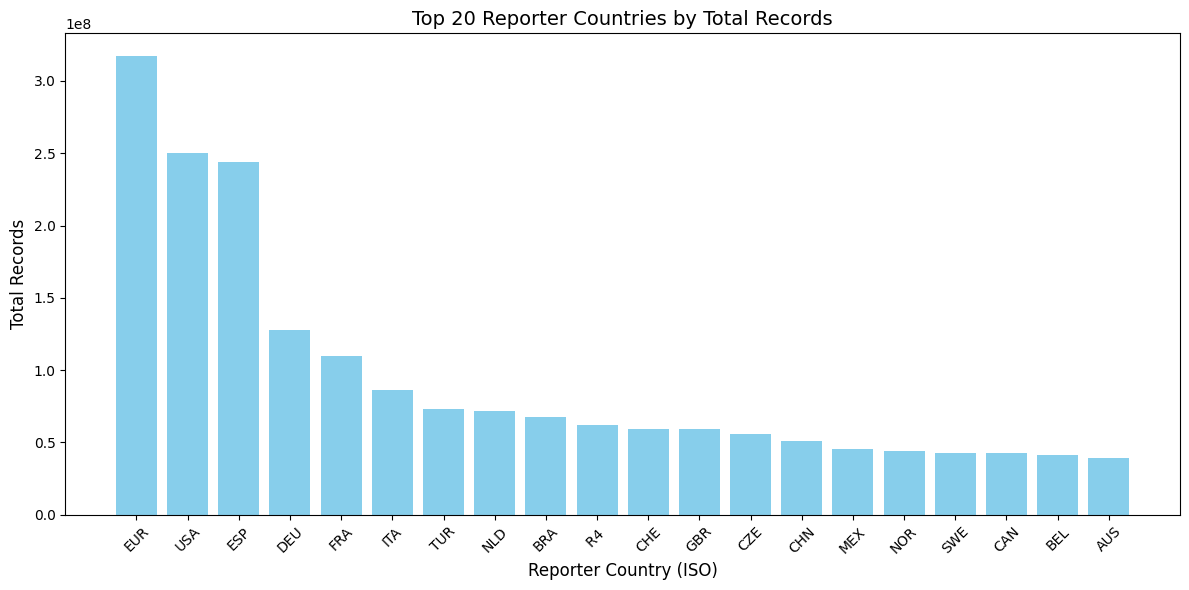

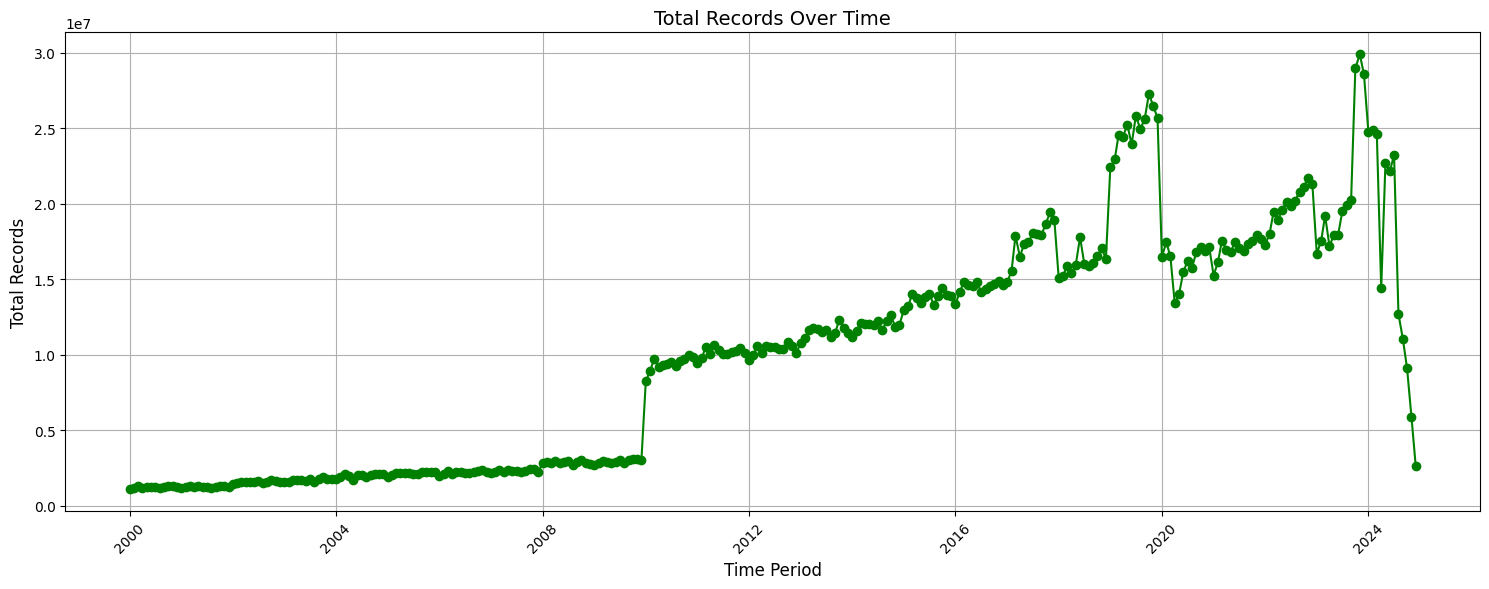

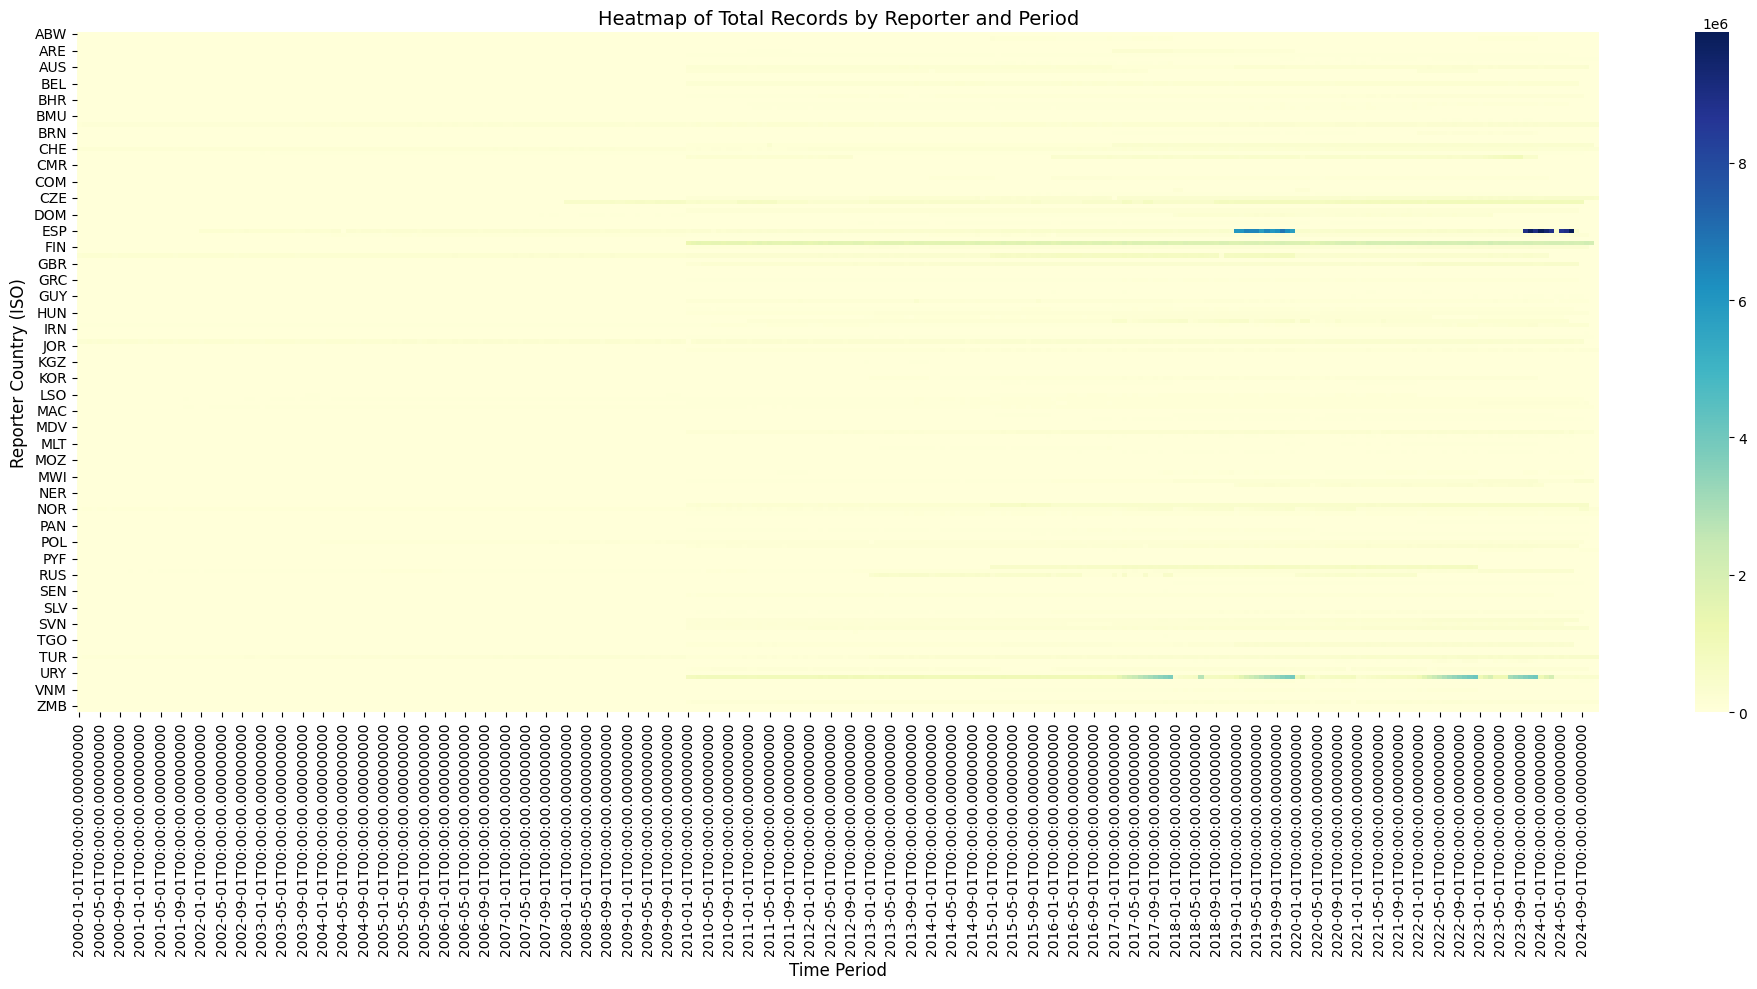

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Bar Plot (Total Records by Reporter Country)
def plot_bar_chart(data, top_n=20):
    """
    Create a bar plot for total records by reporter country.
    Only displays the top N countries by total records.
    """
    # Aggregate total records by Reporter ISO
    aggregated_data = data.groupby("reporterISO")["totalRecords"].sum().reset_index()
    aggregated_data = aggregated_data.sort_values("totalRecords", ascending=False)

    # Limit to the top N countries
    top_countries = aggregated_data.head(top_n)

    # Plot
    plt.figure(figsize=(12, 6))
    plt.bar(top_countries["reporterISO"], top_countries["totalRecords"], color="skyblue")
    plt.title(f"Top {top_n} Reporter Countries by Total Records", fontsize=14)
    plt.xlabel("Reporter Country (ISO)", fontsize=12)
    plt.ylabel("Total Records", fontsize=12)
    plt.xticks(rotation=45, fontsize=10)
    plt.tight_layout()
    plt.show()



# Step 2: Line Plot (Total Records Over Time)
def plot_line_chart(data):
    if "period" in data.columns:
        # Aggregate total records over time
        time_series_data = data.groupby("period")["totalRecords"].sum().reset_index()

        # Plot
        plt.figure(figsize=(15, 6))
        plt.plot(time_series_data["period"], time_series_data["totalRecords"], marker="o", color="green")
        plt.title("Total Records Over Time", fontsize=14)
        plt.xlabel("Time Period", fontsize=12)
        plt.ylabel("Total Records", fontsize=12)
        plt.grid(True)
        plt.xticks(rotation=45, fontsize=10)
        plt.tight_layout()
        plt.show()

# Step 3: Heatmap (Total Records by Reporter and Period)
def plot_heatmap(data):
    if "reporterISO" in data.columns and "period" in data.columns:
        # Create a pivot table for the heatmap
        heatmap_data = data.pivot_table(
            index="reporterISO", columns="period", values="totalRecords", aggfunc="sum", fill_value=0
        )

        # Plot
        plt.figure(figsize=(20, 10))
        sns.heatmap(heatmap_data, cmap="YlGnBu", cbar=True, annot=False)
        plt.title("Heatmap of Total Records by Reporter and Period", fontsize=14)
        plt.xlabel("Time Period", fontsize=12)
        plt.ylabel("Reporter Country (ISO)", fontsize=12)
        plt.xticks(rotation=90, fontsize=10)
        plt.tight_layout()
        plt.show()

# Call the visualization functions
plot_bar_chart(df)
plot_line_chart(df)
plot_heatmap(df)


# Trade Analysis Over Time

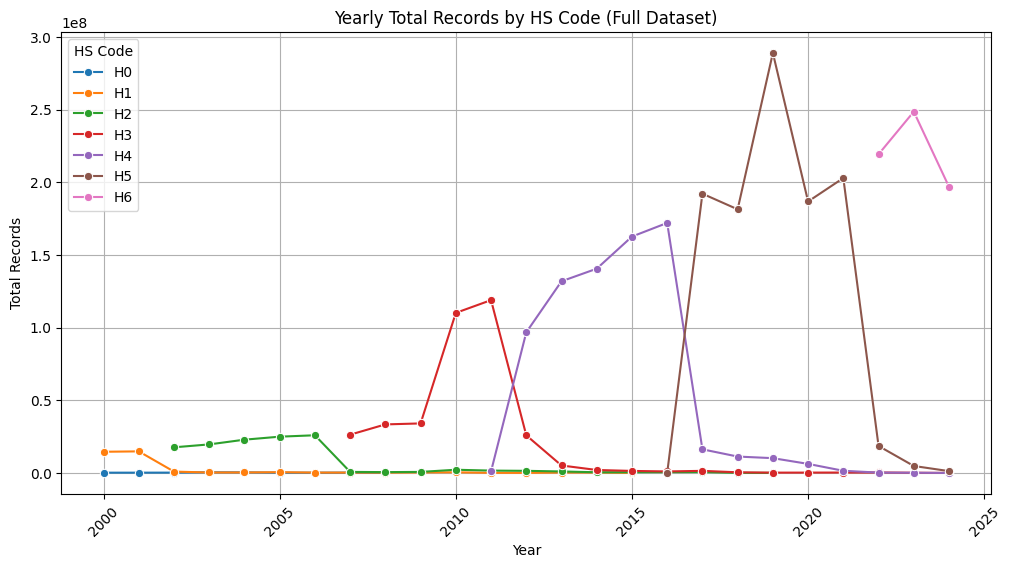

classificationCode,H0,H1,H2,H3,H4,H5,H6
year,,,,,,,
2000,245996.0,14622652.0,NaN,NaN,NaN,NaN,NaN
2001,259250.0,14896769.0,NaN,NaN,NaN,NaN,NaN
2002,284257.0,984132.0,17686565.0,NaN,NaN,NaN,NaN
2003,512654.0,371869.0,19690932.0,NaN,NaN,NaN,NaN
2004,469205.0,392038.0,22941165.0,NaN,NaN,NaN,NaN
2005,213056.0,583984.0,25003560.0,NaN,NaN,NaN,NaN
2006,238321.0,311792.0,25975444.0,NaN,NaN,NaN,NaN
2007,299650.0,310966.0,779880.0,26381960.0,NaN,NaN,NaN
2008,117353.0,274140.0,630864.0,33444203.0,NaN,NaN,NaN


In [41]:
# Extract year from the period column
df["year"] = df["period"].dt.year
# Aggregate total trade records by classificationCode and year
yearly_trend_full = df.groupby(["year", "classificationCode"])["totalRecords"].sum().reset_index()
# Plot yearly trend for each HS Code
plt.figure(figsize=(12, 6))
sns.lineplot(data=yearly_trend_full, x="year", y="totalRecords", hue="classificationCode", marker="o")
# Formatting the plot
plt.title("Yearly Total Records by HS Code (Full Dataset)")
plt.xlabel("Year")
plt.ylabel("Total Records")
plt.grid(True)
plt.xticks(rotation=45)
plt.legend(title="HS Code")
plt.show()
# Pivot the data to create a structured table format
yearly_trend_pivot = yearly_trend_full.pivot(index="year", columns="classificationCode", values="totalRecords")
# Display the structured table
display(yearly_trend_pivot)

# Trade Data from Previous Year

In [42]:
# Filter data for the past year
end_date = df['period'].max()
start_date = end_date - pd.DateOffset(years=1)
df_last_year = df[(df['period'] > start_date) & (df['period'] <= end_date)]

# Display the filtered dataset info
df_last_year.info(), df_last_year.head()

# Save Recent_Year Data
processed_file = "comtrade-output-last-year.csv"
df_last_year.to_csv(processed_file, index=False)
print(f"\nLast_Year data saved to '{processed_file}'.")

<class 'pandas.core.frame.DataFrame'>
Index: 736 entries, 320 to 24505
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   datasetCode               736 non-null    int64         
 1   typeCode                  736 non-null    object        
 2   freqCode                  736 non-null    object        
 3   period                    736 non-null    datetime64[ns]
 4   reporterCode              736 non-null    int64         
 5   reporterISO               736 non-null    object        
 6   classificationCode        736 non-null    object        
 7   isOriginalClassification  736 non-null    bool          
 8   totalRecords              736 non-null    int64         
 9   lengthCmdCode             736 non-null    int64         
 10  firstReleased             736 non-null    object        
 11  lastReleased              736 non-null    object        
 12  year                   

# Overview of Trade Data

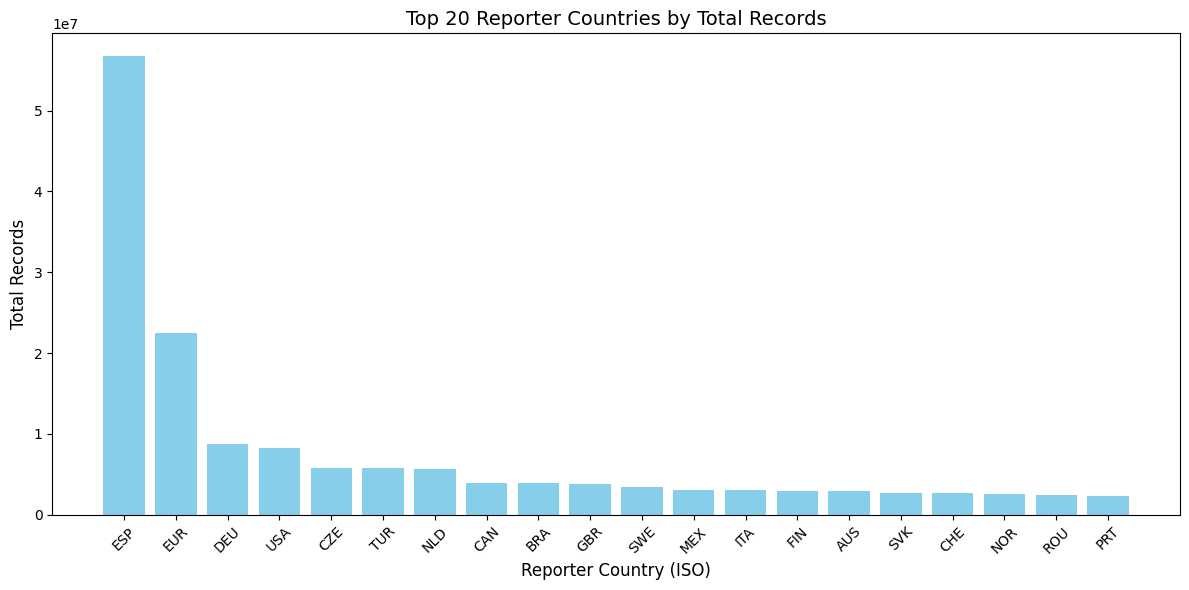

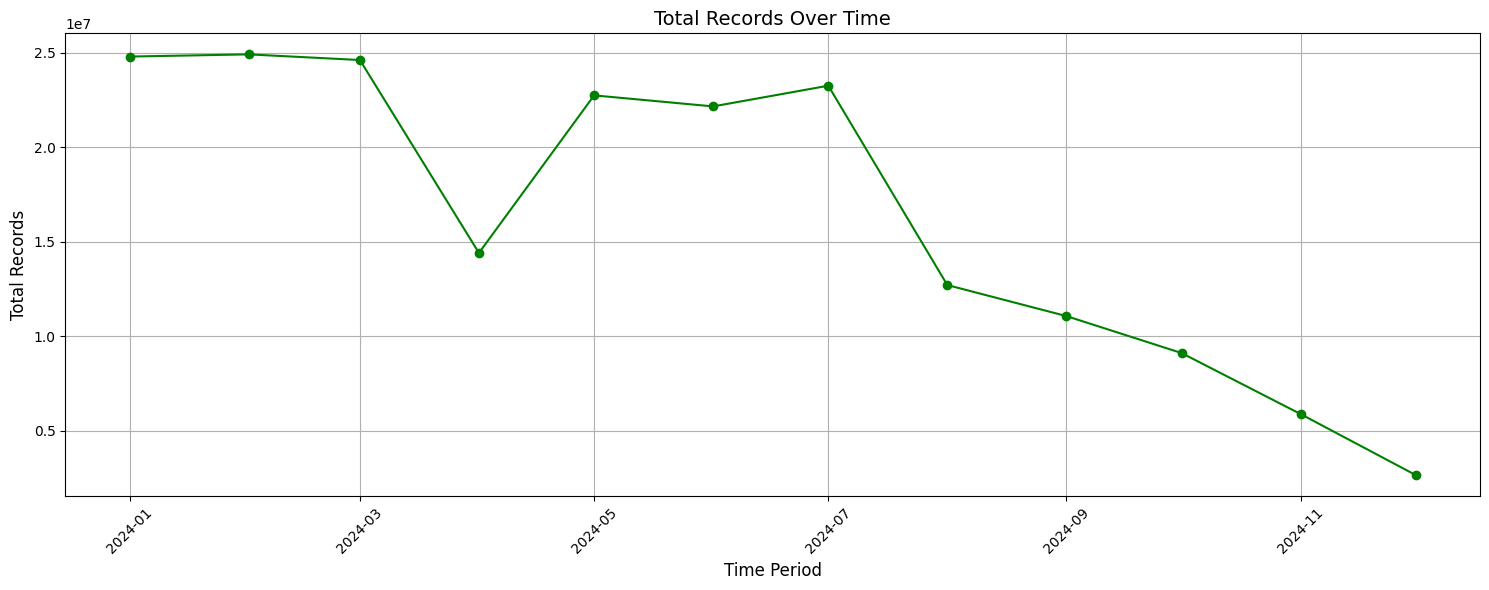

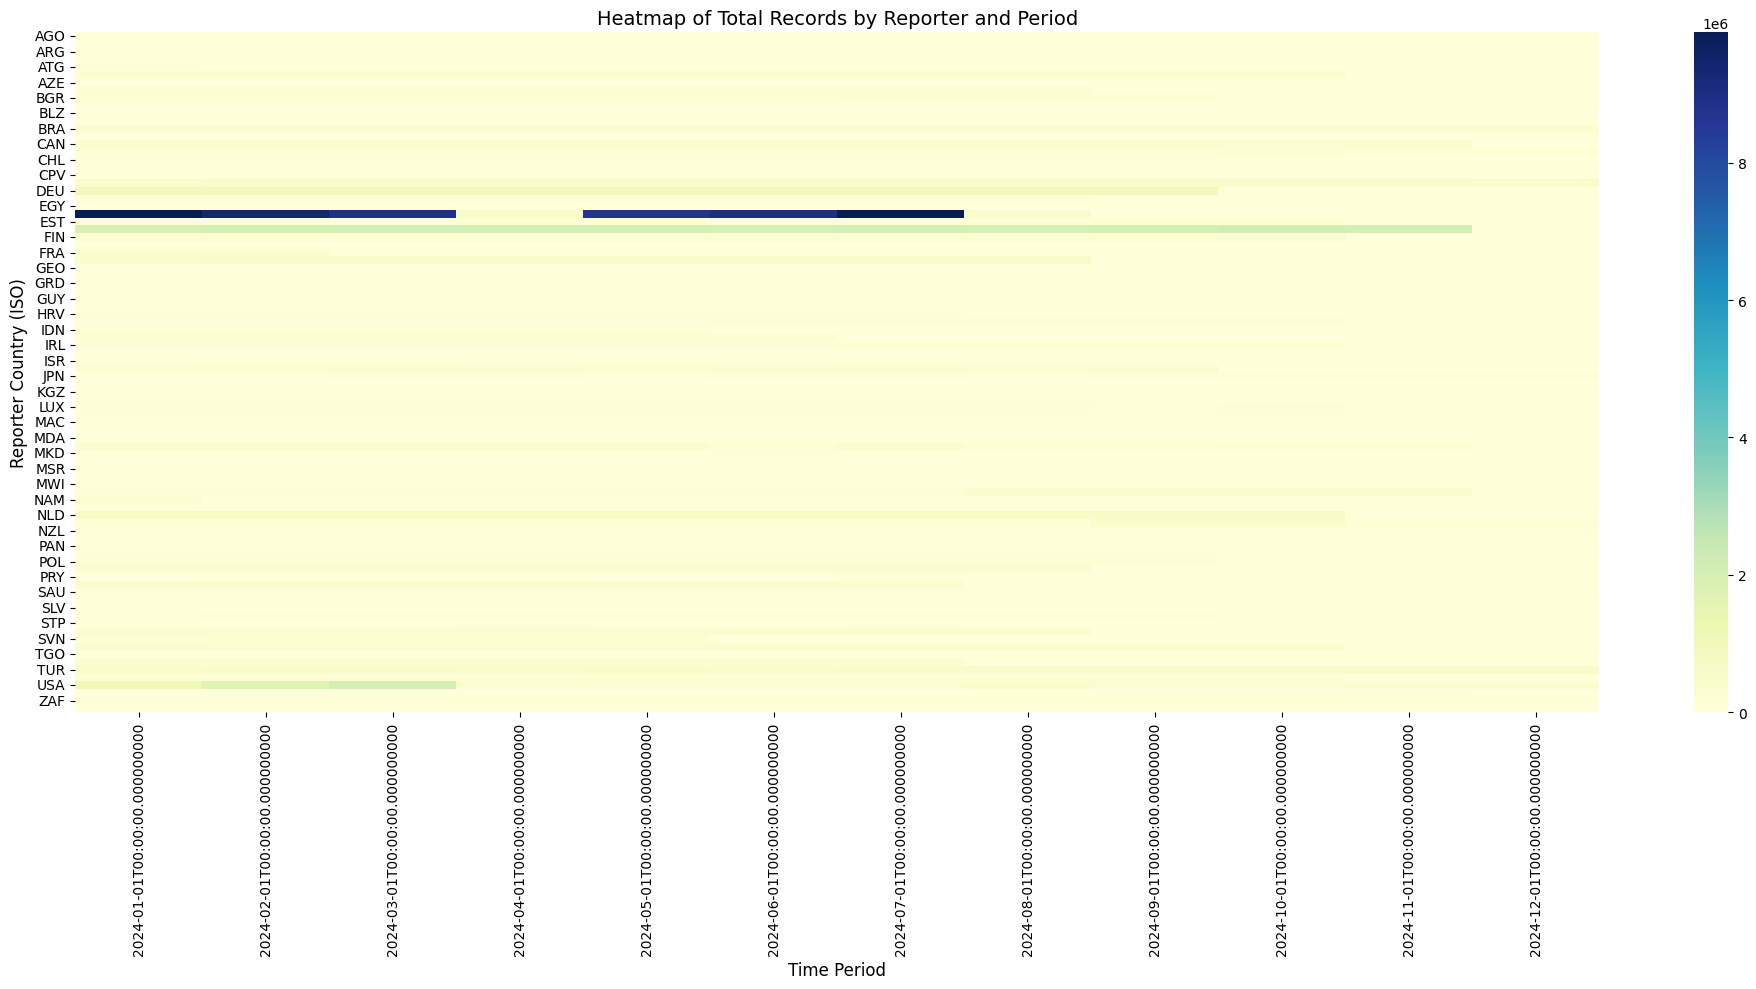

In [43]:
plot_bar_chart(df_last_year)   # Top countries by total records
plot_line_chart(df_last_year)  # Total records over time
plot_heatmap(df_last_year)     # Heatmap of records by country and time

# HS Code Monthly Trends Over Time

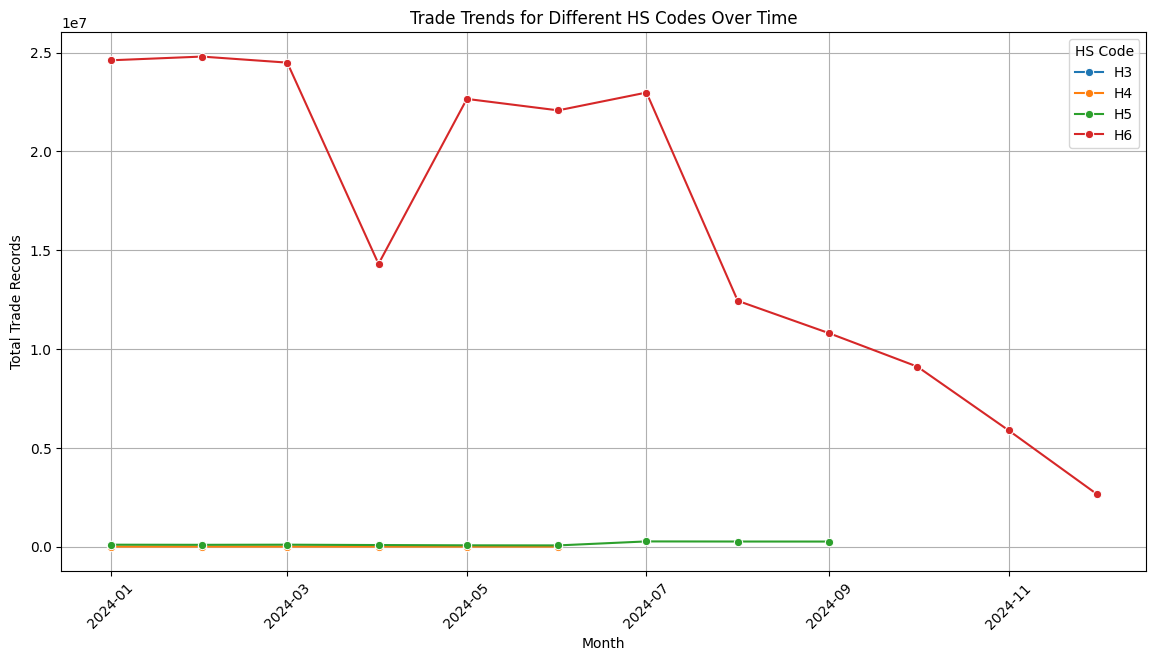

classificationCode,H3,H4,H5,H6
month,,,,
1,65588.0,8474.0,102862.0,24609991.0
2,NaN,8466.0,96586.0,24798302.0
3,NaN,8571.0,103035.0,24492617.0
4,NaN,8675.0,85062.0,14309169.0
5,NaN,7672.0,70736.0,22656257.0
6,NaN,8220.0,66771.0,22076953.0
7,NaN,NaN,268600.0,22977839.0
8,NaN,NaN,263173.0,12441335.0
9,NaN,NaN,261602.0,10803741.0


In [44]:
# Aggregate trade volume by month and HS code
hs_code_trends = df_last_year.groupby(["period", "classificationCode"])["totalRecords"].sum().reset_index()

# Plot trade trends for each HS code
plt.figure(figsize=(14, 7))
sns.lineplot(data=hs_code_trends, x="period", y="totalRecords", hue="classificationCode", marker="o")
plt.title("Trade Trends for Different HS Codes Over Time")
plt.xlabel("Month")
plt.ylabel("Total Trade Records")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title="HS Code")
plt.show()

# Extract the month from the 'period' column
hs_code_trends['month'] = hs_code_trends['period'].dt.month

# Pivot the data to create a structured table format
monthly_trend_pivot = hs_code_trends.pivot(index="month", columns="classificationCode", values="totalRecords")

# Display the structured table
display(monthly_trend_pivot)

# Month-over-Month (MoM) Growth Analysis

<ipython-input-45-12b2a0f9638e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_last_year["totalRecords_pct_change"] = df_last_year.groupby("classificationCode")["totalRecords"].pct_change() * 100


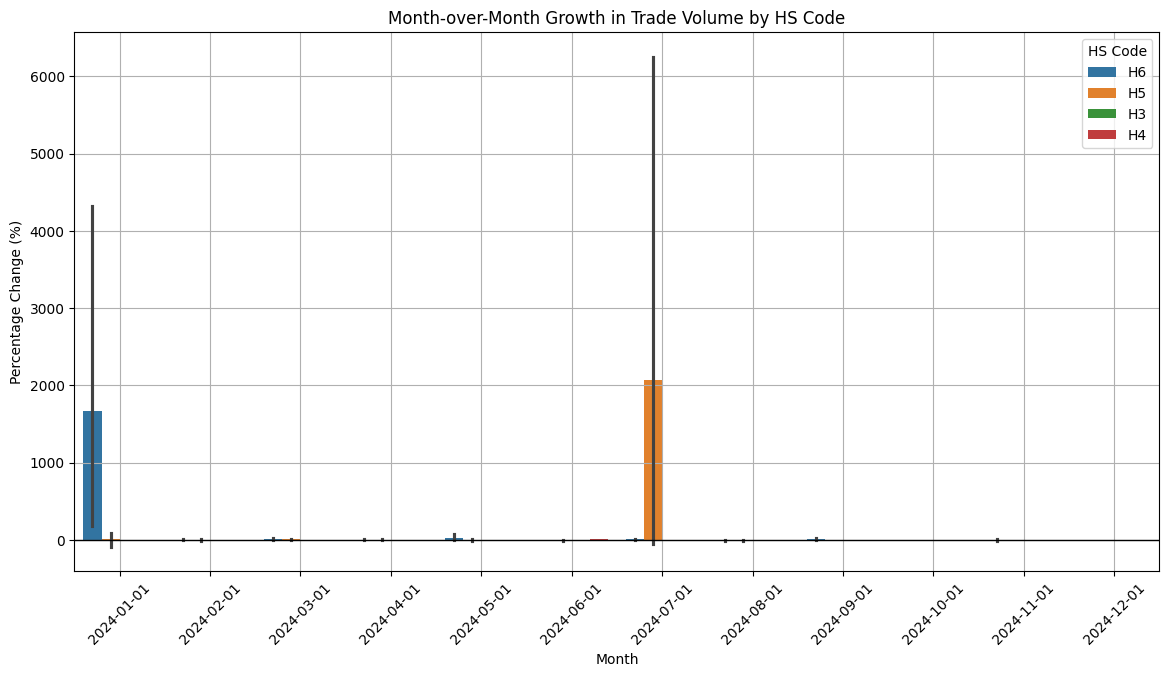

In [45]:
# Calculate month-over-month growth rate
df_last_year["totalRecords_pct_change"] = df_last_year.groupby("classificationCode")["totalRecords"].pct_change() * 100

# Plot MoM changes
plt.figure(figsize=(14, 7))
sns.barplot(data=df_last_year, x="period", y="totalRecords_pct_change", hue="classificationCode")
plt.title("Month-over-Month Growth in Trade Volume by HS Code")
plt.xlabel("Month")
plt.ylabel("Percentage Change (%)")
plt.xticks(rotation=45)
plt.axhline(0, color="black", linewidth=1)
plt.grid(True)
plt.legend(title="HS Code")
plt.show()


# Anomaly Detection

In [46]:
# Compute Z-score for totalRecords
df_last_year["z_score"] = (df_last_year["totalRecords"] - df_last_year["totalRecords"].mean()) / df_last_year["totalRecords"].std()

# Identify outliers (Z-score > 3)
anomalies = df_last_year[df_last_year["z_score"].abs() > 3]

# Display anomalies
display(anomalies)


<ipython-input-46-f0311de1eaac>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_last_year["z_score"] = (df_last_year["totalRecords"] - df_last_year["totalRecords"].mean()) / df_last_year["totalRecords"].std()


,datasetCode,typeCode,freqCode,period,reporterCode,reporterISO,classificationCode,isOriginalClassification,totalRecords,lengthCmdCode,firstReleased,lastReleased,year,totalRecords_pct_change,z_score
21357,30724202401202100,C,M,2024-01-01,724,ESP,H6,True,9897491,10,2024-05-02T07:03:18.4233333,2024-05-02T07:03:18.4233333,2024,99172.728185,11.041242
21358,30724202402202100,C,M,2024-02-01,724,ESP,H6,True,9396322,10,2024-05-02T12:37:30.13,2024-05-02T12:37:30.13,2024,-5.063596,10.466516
21359,30724202403202100,C,M,2024-03-01,724,ESP,H6,True,8879474,10,2024-06-01T15:33:15.4466667,2024-06-01T15:33:15.4466667,2024,-5.500535,9.873810
21361,30724202405202100,C,M,2024-05-01,724,ESP,H6,True,8733935,10,2024-08-28T12:29:05.6666667,2024-08-28T12:29:05.6666667,2024,1626.418712,9.706911
21362,30724202406202100,C,M,2024-06-01,724,ESP,H6,True,8949922,10,2024-08-28T12:26:03.3766667,2024-08-28T12:26:03.3766667,2024,2.472963,9.954598
21363,30724202407202100,C,M,2024-07-01,724,ESP,H6,True,9886351,10,2024-12-07T08:46:21.98,2024-12-07T08:46:21.98,2024,10.462985,11.028467
